In [1]:
import scanpy as sc
import scvi
import glob
import os
from functools import reduce
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sctools import integrate, plot, io

Global seed set to 0


## Cell abundance analysis with Milo

In [22]:
# load data
results = {}
for key in ['tcells.tissue.scps', 'tcells.tissue.ad', 'tcells.tissue.uc', 'tcells.pmbc.scps']:
    results[key] = {}
    results[key]['data'] = sc.read_h5ad(
        format_string.format(k = key)
    )

In [13]:
results['tcells_full']['data'].obs.status.unique()

['UC', 'control']
Categories (2, object): ['UC', 'control']

In [14]:
import os
os.environ['R_HOME'] = '/users/daniel.malzl/.conda/envs/scpython/lib/R'
os.environ['TZ'] = 'Europe/Vienna' # needs to be set in some cases to avoid tzlocal error

In [15]:
import milopy
import milopy.core as milo

control_conditions = {
    'tcells.tissue.scps': 'normal', 
    'tcells.tissue.ad': 'normal', 
    'tcells.tissue.uc': 'control', 
    'tcells.pmbc.scps': 'normal'
}
for k, d in results.items():
    adata = d['data']
    adata.obs['condition'] = 'healthy'
    adata.obs.loc[adata.obs.status != control_conditions[k], 'condition'] = 'disease'
    # needs to be done in order to enforce disease vs healthy comparison
    # otherwise will take alphabetical order and do healthy vs disease
    adata.obs.loc[:, 'condition'] = pd.Categorical(
        adata.obs.condition,
        categories = ['healthy', 'disease']
    )
    milo.make_nhoods(adata)
    milo.count_nhoods(adata, sample_col = 'sample_id')
    milo.DA_nhoods(adata, design="~condition")

/tmp/ipykernel_24433/1559426760.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata.obs.loc[:, 'condition'] = pd.Categorical(
/users/daniel.malzl/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/site-packages/rpy2/robjects/vectors.py:1017: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/users/daniel.malzl/.conda/envs/scpython/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argumen

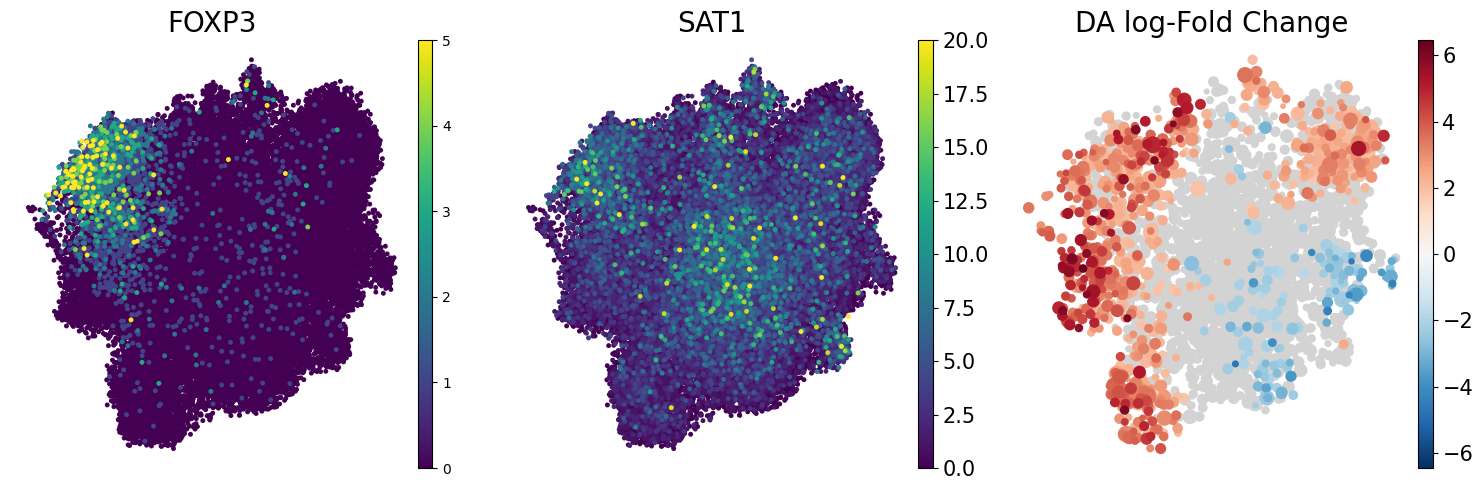

In [16]:
for i, (k, d) in enumerate(results.items()):
    fig, axs = plt.subplots(1, 3)
    adata = d['data']
    sc.pl.umap(
        adata,
        color = 'FOXP3',
        frameon = False,
        show = False,
        size = 50,
        ax = axs[0],
        vmax = 5
    )
    
    sc.pl.umap(
        adata,
        color = 'SAT1',
        frameon = False,
        show = False,
        size = 50,
        ax = axs[1],
        vmax = 20
    )
    
        
    milopy.utils.build_nhood_graph(adata)
    milopy.plot.plot_nhood_graph(
        adata, 
        alpha=0.1, 
        min_size=5, 
        ax = axs[2], 
        show = False
    )
    for ax in axs:
        ax.set_title(ax.get_title(), fontsize = 20)
        
    for ax in fig.axes[-2:]:
        ax.tick_params(
            labelsize = 15
        )
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.tight_layout()